!pip install opencv-python==4.5.5.64
!pip install scikit-learn==1.4.1.post1
!pip install scipy==1.12.0
!pip install tensorflow==2.17.0

In [66]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:

def load_vehicle_images(csv_file, image_dir, target_size=(224, 224)):
    df = pd.read_csv(csv_file)
    print(df.columns)
    images = []
    bboxes = []
    for _, row in df.iterrows():
        img_path = f"{image_dir}/{row['img_id']}"
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image
        img = cv2.resize(img, target_size)
        
        images.append(img)
        
        # Normalize bounding box coordinates
        h, w = img.shape[:2]
        ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']
        bboxes.append([ymin/h, xmin/w, ymax/h, xmax/w])
    
    return np.array(images), np.array(bboxes)


In [3]:
# Usage
csv_file = 'Licplatesdetection_train.csv'
image_dir = 'Licplatesdetection_train/license_plates_detection_train'
vechile_images, bboxes = load_vehicle_images(csv_file, image_dir)

print(f"Images shape: {vechile_images.shape}")
print(f"Bounding boxes shape: {bboxes.shape}")

Index(['img_id', 'ymin', 'xmin', 'ymax', 'xmax'], dtype='object')
Images shape: (900, 224, 224, 3)
Bounding boxes shape: (900, 4)


In [22]:

def load_plate_images(csv_file, image_dir, target_size=(224, 224)):
    df = pd.read_csv(csv_file)
    print(f"Total rows in CSV: {len(df)}")
    print(f"CSV columns: {df.columns}")
    
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = f"{image_dir}/{row['img_id']}"
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image {img_path}")
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image
        img = cv2.resize(img, target_size)
        
        images.append(img)
        labels.append(row['text'])
    
    return np.array(images), np.array(labels)



In [23]:
# Usage
csv_file = 'Licplatesrecognition_train.csv'
image_dir = 'Licplatesrecognition_train/license_plates_recognition_train'
plate_images, labels = load_plate_images(csv_file, image_dir)

print(f"Images shape: {plate_images.shape}")
print(f"Labels shape: {labels.shape}")

Total rows in CSV: 900
CSV columns: Index(['img_id', 'text'], dtype='object')
Images shape: (900, 224, 224, 3)
Labels shape: (900,)


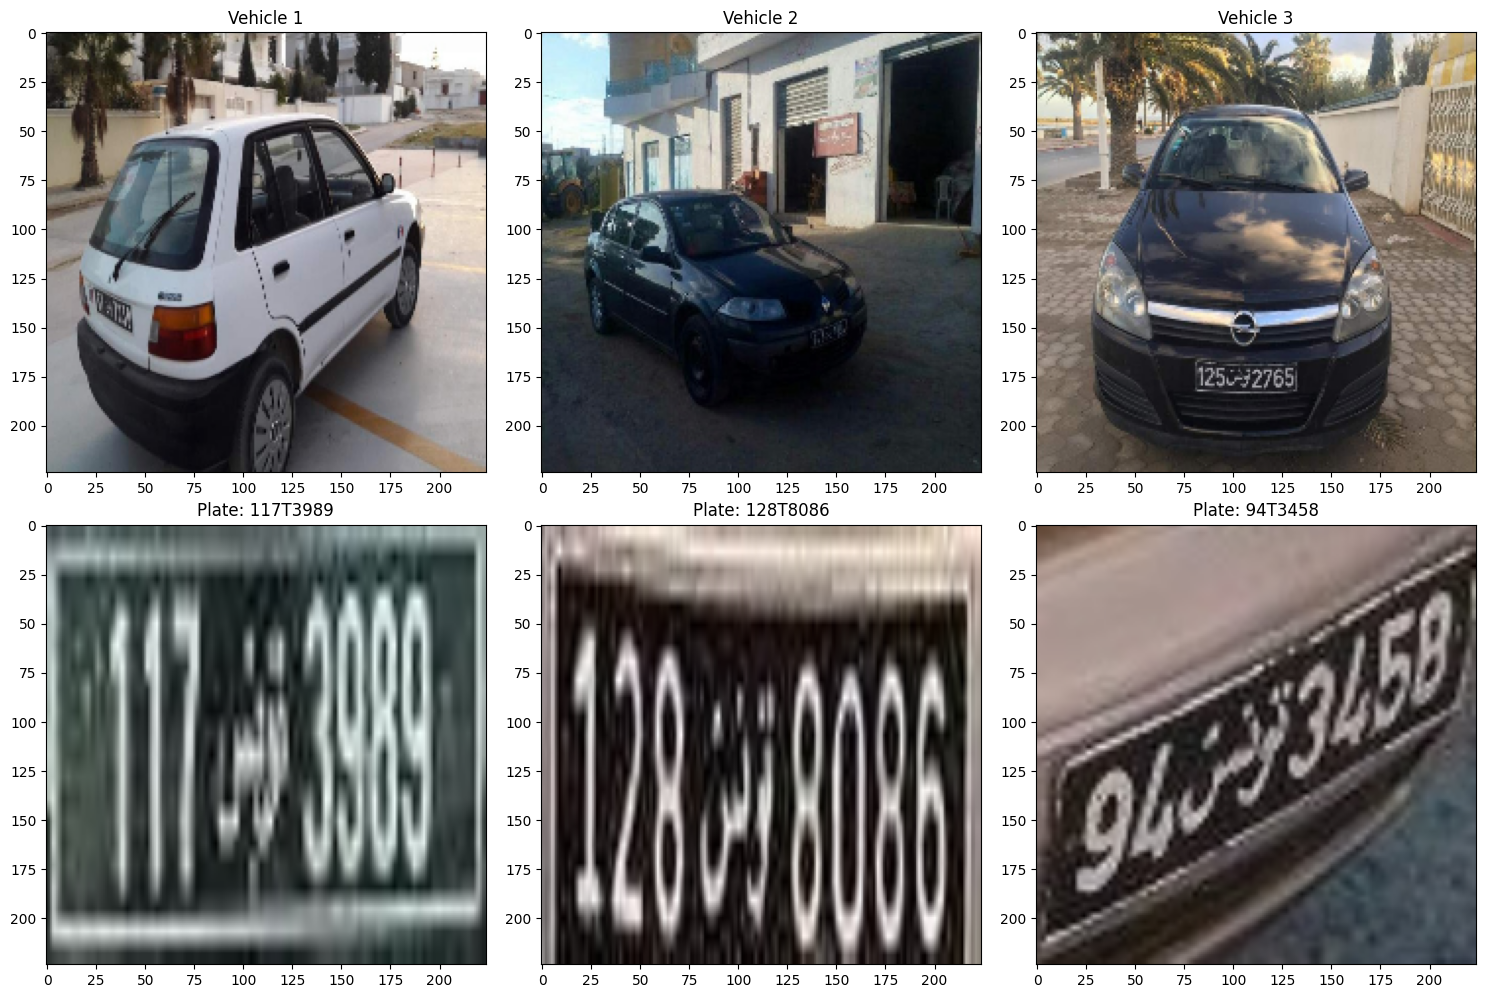

In [6]:
# Display sample images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    axes[0, i].imshow(vechile_images[i])
    axes[0, i].set_title(f"Vehicle {i+1}")
    axes[1, i].imshow(plate_images[i])
    axes[1, i].set_title(f"Plate: {labels[i]}")
plt.tight_layout()
plt.show()

!pip install tensorflow

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [11]:
# Prepare data for license plate detection
X_train, X_val, y_train, y_val = train_test_split(vechile_images,bboxes, test_size=0.2, random_state=42)


In [12]:
# Create the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='linear')(x)  # 4 outputs for bounding box coordinates

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step


In [13]:
# Compile and train the model
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 189s 5s/step - loss: 2.6410 - val_loss: 115.8623
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - loss: 0.1174 - val_loss: 68.2821
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - loss: 0.0597 - val_loss: 61.9440
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - loss: 0.0372 - val_loss: 67.7162
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - loss: 0.0287 - val_loss: 64.4817
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 0.0273 - val_loss: 50.0151
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - loss: 0.0275 - val_loss: 45.2992
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - loss: 0.0231 - val_loss: 44.0542
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - loss: 0.0208 - val_loss: 33.3055
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - loss: 0.0205 - val_loss: 28.2628
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - loss: 0.0209 - val_loss: 21.7410
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - loss

In [14]:
# Save the model
model.save('license_plate_detector.h5')

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [43]:
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_plate_images(csv_file, image_dir, target_size=(224, 224)):
    df = pd.read_csv(csv_file)
    print(f"Total rows in CSV: {len(df)}")
    print(f"CSV columns: {df.columns}")
    
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = f"{image_dir}/{row['img_id']}"
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image {img_path}")
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        
        images.append(img)
        labels.append(row['text'])
    
    return np.array(images), np.array(labels)

# Load the data
csv_file = 'Licplatesrecognition_train.csv'
image_dir = 'Licplatesrecognition_train/license_plates_recognition_train'
images, labels = load_plate_images(csv_file, image_dir)

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {encoded_labels.shape}")
print(f"Number of unique classes: {len(label_encoder.classes_)}")

# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

def create_model(num_classes,input_shape=(224, 224, 3)):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the model
input_shape = (224, 224, 3)  # Adjust if your image dimensions are different
num_classes = len(label_encoder.classes_)
model = create_model(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Total rows in CSV: 900
CSV columns: Index(['img_id', 'text'], dtype='object')
Images shape: (900, 224, 224, 3)
Labels shape: (900,)
Number of unique classes: 596
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.0000e+00 - loss: 28.3976 - val_accuracy: 0.0111 - val_loss: 6.3945
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 835ms/step - accuracy: 0.0014 - loss: 6.3859 - val_accuracy: 0.0000e+00 - val_loss: 6.4019
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 733ms/step - accuracy: 0.0015 - loss: 6.3818 - val_accuracy: 0.0000e+00 - val_loss: 6.4094
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.0086 - loss: 6.3776 - val_accuracy: 0.0000e+00 - val_loss: 6.4168
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.0075 - loss: 6.3740 - val_accuracy: 0.0000e+00 - val_loss: 6.4243
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 762ms/step - accuracy: 0.0071 - loss: 6.3707 - val_accuracy: 0.0222 - val_loss: 6.4318
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 671ms/step

In [44]:
# Save the model
model.save('character_recognition.h5')

In [48]:
def load_test_images(image_dir, target_size=(224, 224)):
    images = []
    for i in range(901,1113):
        img_path = f"{image_dir}/{str(i)+'.jpg'}"
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image
        img = cv2.resize(img, target_size)
        
        images.append(img)
        
        # Normalize bounding box coordinates
        h, w = img.shape[:2]
    
    return np.array(images)

In [49]:
# Test on the test set
test_images = load_test_images('test/test/test')

In [55]:
import tensorflow as tf

# Register the custom mse function
@tf.keras.utils.register_keras_serializable()
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Load the model with the custom object
plate_detector = tf.keras.models.load_model('license_plate_detector.h5', custom_objects={'mse': mse})


In [56]:
# Recognize characters
char_recognizer = tf.keras.models.load_model('character_recognition.h5')

In [60]:
import numpy as np

def detect_and_recognize(img):
    # Detect license plate
    bbox = plate_detector.predict(np.expand_dims(img, axis=0))[0]
    
    # Extract bounding box coordinates
    ymin, xmin, ymax, xmax = map(int, bbox)
    
    # Clip coordinates to stay within image boundaries
    ymin = max(0, ymin)
    xmin = max(0, xmin)
    ymax = min(img.shape[0], ymax)
    xmax = min(img.shape[1], xmax)
    
    # Extract license plate region
    plate_img = img[ymin:ymax, xmin:xmax]
    
    # Check if the region has valid dimensions
    if plate_img.shape[0] == 0 or plate_img.shape[1] == 0:
        return "Invalid plate region"
    
    # Check if the region is large enough to be processed
    if plate_img.shape[0] < 20 or plate_img.shape[1] < 20:  # Example threshold, adjust as necessary
        return "Plate region too small"
    
    # Recognize characters on the plate
    plate_number = char_recognizer.predict(np.expand_dims(plate_img, axis=0))[0]
    
    return plate_number

results = []

for img in test_images:
    plate_number = detect_and_recognize(img)
    results.append(plate_number)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

In [61]:
print(results[0])

Invalid plate region


In [62]:
for i in results:
    print(i)

Invalid plate region
Invalid plate region
Plate region too small
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Plate region too small
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Plate region too small
Invalid plate region
Invalid plate region
Plate region too small
Invalid plate region
Plate region too small
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Plate region too small
Invalid plate region
Invalid plate region
Invalid plate region
Plate region too small
Plate region too small
Invalid plate region
Invalid plate region
Plate region too small
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate region
Invalid plate re

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
anyio                        4.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.11.0
beautifulsoup4               4.12.2
bleach                       4.1.0
blinker                      1.7.0
Brotli                       1.0.9
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           2.0.4
click                        8.1.7
colorama                     0.4.6
comm                         0.1.2
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1
executing                    0.8.3
fastjsonschema               2.16.2


In [65]:
scikit-learn                 1.4.1.post1
scipy                        1.12.0
tensorflow                   2.17.0

SyntaxError: invalid syntax (3689130577.py, line 1)